# Mean Squared Error (MSE): La Métrica Sensible para Regresión

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.datasets import make_regression
import seaborn as sns
from scipy import stats

# Configuración general
np.random.seed(42)
plt.style.use('seaborn-v0_8')


In [4]:
# Generar datos sintéticos más realistas
def generate_temperature_data(n_samples=1000):
    """Simula datos de temperatura de un data center"""
    X = np.random.randn(n_samples, 4)
    temperature = (
        25 +
        8 * X[:, 0] +      # Carga CPU
        5 * X[:, 1] +      # Temperatura ambiente
        -3 * X[:, 2] +     # Eficiencia refrigeración
        2 * X[:, 3] +      # Número de procesos
        1.5 * X[:, 0] * X[:, 1] +  # Interacción CPU-ambiente
        np.random.normal(0, 2, n_samples)  # Ruido
    )
    outlier_indices = np.random.choice(n_samples, size=int(0.02 * n_samples), replace=False)
    temperature[outlier_indices] += np.random.normal(0, 15, len(outlier_indices))
    return X, temperature

# Generar datos
X, y = generate_temperature_data(1200)


In [6]:
# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Escalamiento para regresión lineal
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [8]:
# Entrenar modelos
linear_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

linear_model.fit(X_train_scaled, y_train)
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [10]:
# Predicciones
y_pred_linear = linear_model.predict(X_test_scaled)
y_pred_rf = rf_model.predict(X_test)

# Cálculo de métricas
mse_linear = mean_squared_error(y_test, y_pred_linear)
mse_rf = mean_squared_error(y_test, y_pred_rf)

mae_linear = mean_absolute_error(y_test, y_pred_linear)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

rmse_linear = np.sqrt(mse_linear)
rmse_rf = np.sqrt(mse_rf)

r2_linear = r2_score(y_test, y_pred_linear)
r2_rf = r2_score(y_test, y_pred_rf)

# Mostrar resultados
print("=== COMPARACIÓN DE MODELOS ===")
print(f"Regresión Lineal:")
print(f"  MSE:  {mse_linear:.2f} °C²")
print(f"  RMSE: {rmse_linear:.2f} °C")
print(f"  MAE:  {mae_linear:.2f} °C")
print(f"  R²:   {r2_linear:.3f}\n")

print(f"Random Forest:")
print(f"  MSE:  {mse_rf:.2f} °C²")
print(f"  RMSE: {rmse_rf:.2f} °C")
print(f"  MAE:  {mae_rf:.2f} °C")
print(f"  R²:   {r2_rf:.3f}")


=== COMPARACIÓN DE MODELOS ===
Regresión Lineal:
  MSE:  10.32 °C²
  RMSE: 3.21 °C
  MAE:  2.06 °C
  R²:   0.906

Random Forest:
  MSE:  12.68 °C²
  RMSE: 3.56 °C
  MAE:  2.47 °C
  R²:   0.884


In [12]:
# Verificación de cálculo manual
mse_manual = np.mean((y_test - y_pred_linear) ** 2)
print(f"\nVerificación MSE manual: {mse_manual:.2f}")
print(f"MSE de sklearn: {mse_linear:.2f}")
print(f"Diferencia: {abs(mse_manual - mse_linear):.10f}")



Verificación MSE manual: 10.32
MSE de sklearn: 10.32
Diferencia: 0.0000000000


In [14]:
# Análisis de sensibilidad a outliers
errors_linear = y_test - y_pred_linear
errors_rf = y_test - y_pred_rf

# Detectar outliers (> 2 desviaciones estándar)
threshold_linear = 2 * np.std(errors_linear)
threshold_rf = 2 * np.std(errors_rf)

outliers_linear = np.abs(errors_linear) > threshold_linear
outliers_rf = np.abs(errors_rf) > threshold_rf

print("\n=== ANÁLISIS DE OUTLIERS ===")
print("Regresión Lineal:")
print(f"  Outliers detectados: {np.sum(outliers_linear)}")
print(f"  Contribución MSE outliers: {np.mean(errors_linear[outliers_linear]**2):.2f}")
print(f"  MSE sin outliers: {np.mean(errors_linear[~outliers_linear]**2):.2f}")

print("\nRandom Forest:")
print(f"  Outliers detectados: {np.sum(outliers_rf)}")
print(f"  Contribución MSE outliers: {np.mean(errors_rf[outliers_rf]**2):.2f}")
print(f"  MSE sin outliers: {np.mean(errors_rf[~outliers_rf]**2):.2f}")



=== ANÁLISIS DE OUTLIERS ===
Regresión Lineal:
  Outliers detectados: 7
  Contribución MSE outliers: 186.33
  MSE sin outliers: 5.03

Random Forest:
  Outliers detectados: 4
  Contribución MSE outliers: 283.37
  MSE sin outliers: 8.09


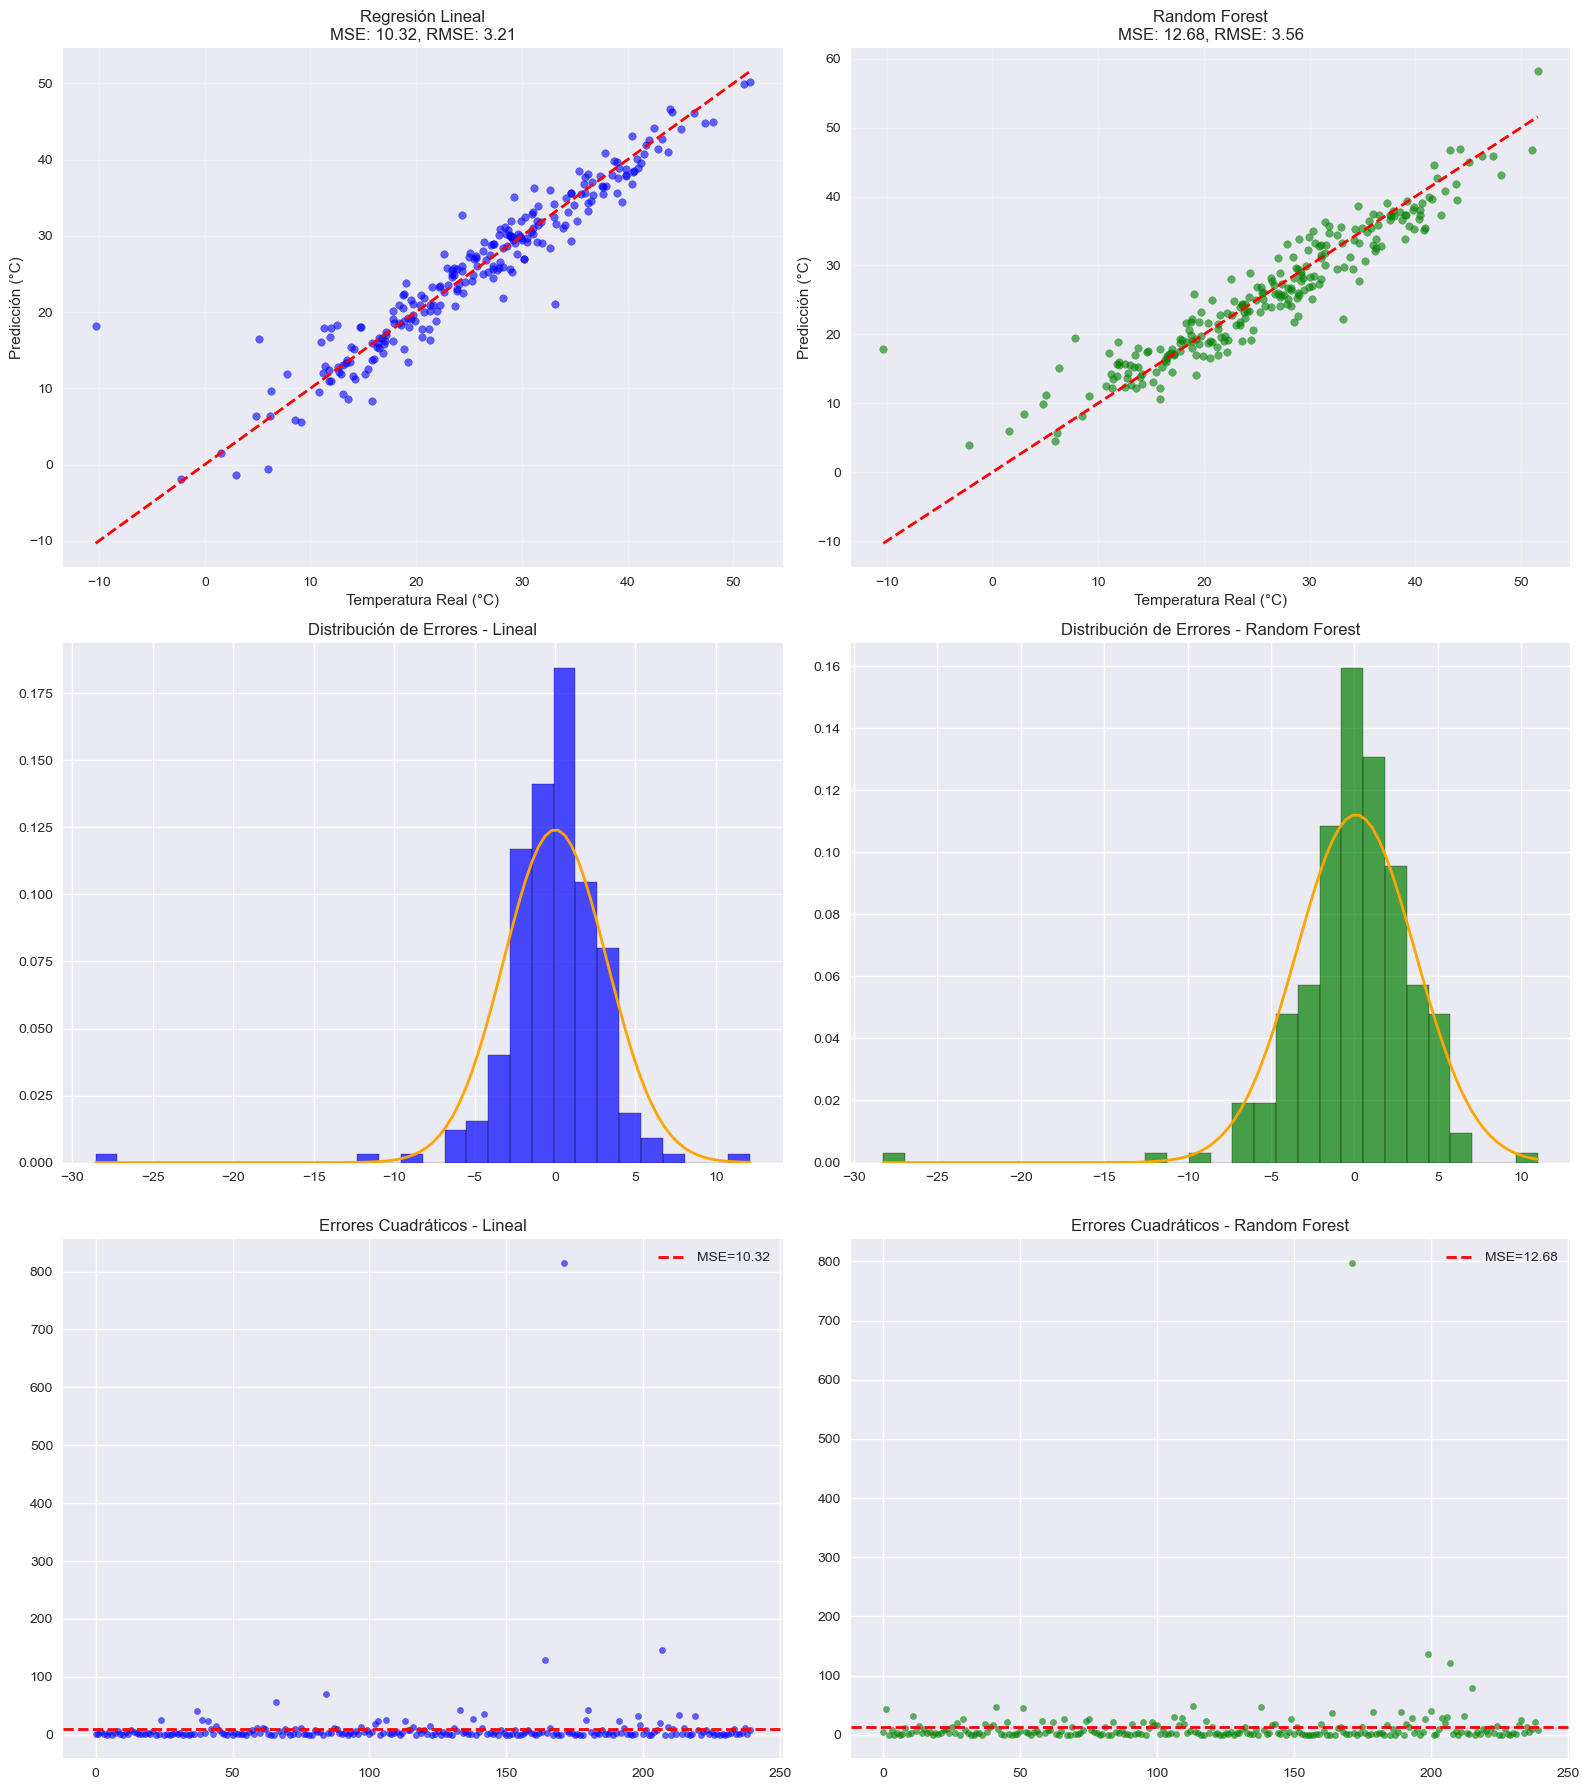

In [16]:
# Crear visualizaciones comprehensivas
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# Predicciones vs reales
axes[0, 0].scatter(y_test, y_pred_linear, alpha=0.6, color='blue', s=30)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Temperatura Real (°C)')
axes[0, 0].set_ylabel('Predicción (°C)')
axes[0, 0].set_title(f'Regresión Lineal\nMSE: {mse_linear:.2f}, RMSE: {rmse_linear:.2f}')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].scatter(y_test, y_pred_rf, alpha=0.6, color='green', s=30)
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Temperatura Real (°C)')
axes[0, 1].set_ylabel('Predicción (°C)')
axes[0, 1].set_title(f'Random Forest\nMSE: {mse_rf:.2f}, RMSE: {rmse_rf:.2f}')
axes[0, 1].grid(True, alpha=0.3)

# Distribución de errores + curva normal
x_norm = np.linspace(errors_linear.min(), errors_linear.max(), 100)
axes[1, 0].hist(errors_linear, bins=30, density=True, color='blue', alpha=0.7, edgecolor='black')
axes[1, 0].plot(x_norm, stats.norm.pdf(x_norm, np.mean(errors_linear), np.std(errors_linear)), 'orange', lw=2)
axes[1, 0].set_title('Distribución de Errores - Lineal')

x_norm_rf = np.linspace(errors_rf.min(), errors_rf.max(), 100)
axes[1, 1].hist(errors_rf, bins=30, density=True, color='green', alpha=0.7, edgecolor='black')
axes[1, 1].plot(x_norm_rf, stats.norm.pdf(x_norm_rf, np.mean(errors_rf), np.std(errors_rf)), 'orange', lw=2)
axes[1, 1].set_title('Distribución de Errores - Random Forest')

# Errores cuadráticos individuales
squared_errors_linear = errors_linear ** 2
squared_errors_rf = errors_rf ** 2

axes[2, 0].scatter(range(len(squared_errors_linear)), squared_errors_linear, alpha=0.6, color='blue', s=20)
axes[2, 0].axhline(mse_linear, color='red', linestyle='--', lw=2, label=f'MSE={mse_linear:.2f}')
axes[2, 0].legend()
axes[2, 0].set_title('Errores Cuadráticos - Lineal')

axes[2, 1].scatter(range(len(squared_errors_rf)), squared_errors_rf, alpha=0.6, color='green', s=20)
axes[2, 1].axhline(mse_rf, color='red', linestyle='--', lw=2, label=f'MSE={mse_rf:.2f}')
axes[2, 1].legend()
axes[2, 1].set_title('Errores Cuadráticos - Random Forest')

plt.tight_layout()
plt.show()


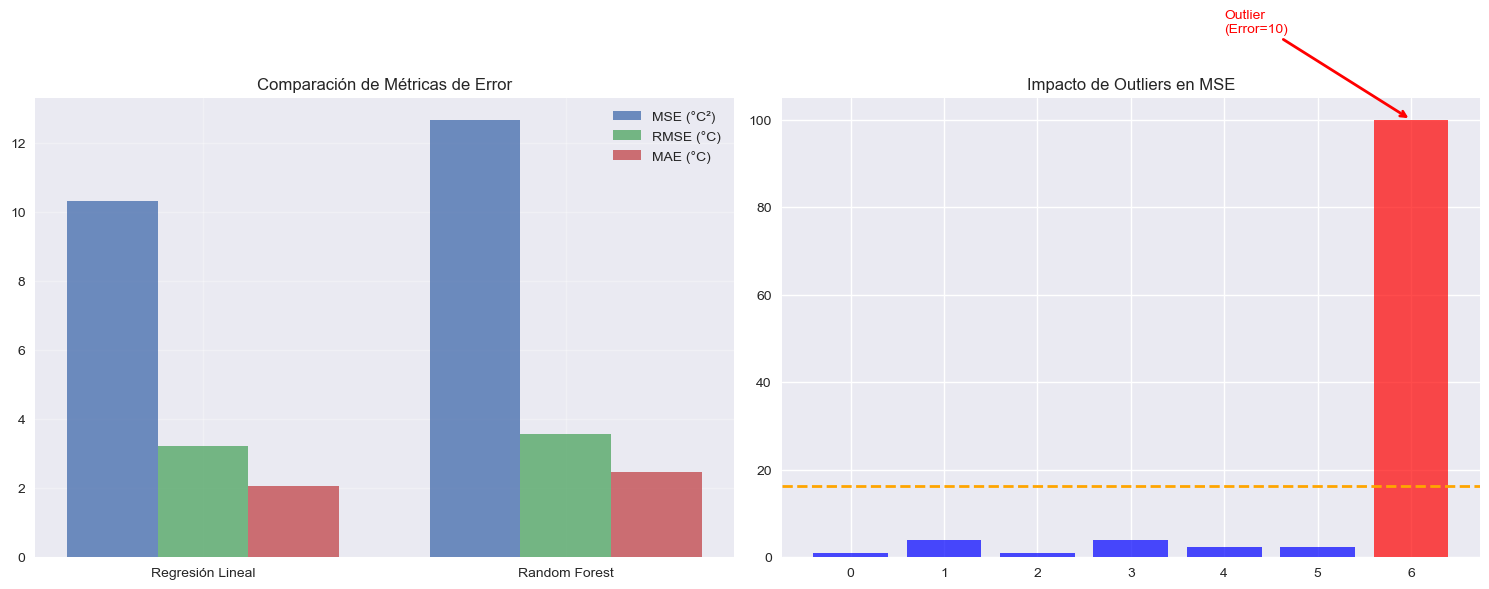

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Comparación de métricas en barras
models = ['Regresión Lineal', 'Random Forest']
mse_values = [mse_linear, mse_rf]
rmse_values = [rmse_linear, rmse_rf]
mae_values = [mae_linear, mae_rf]

x = np.arange(len(models))
width = 0.25

bars1 = ax1.bar(x - width, mse_values, width, label='MSE (°C²)', alpha=0.8)
bars2 = ax1.bar(x, rmse_values, width, label='RMSE (°C)', alpha=0.8)
bars3 = ax1.bar(x + width, mae_values, width, label='MAE (°C)', alpha=0.8)

ax1.set_title('Comparación de Métricas de Error')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Efecto de outliers
errors_example = np.array([1, 2, -1, -2, 1.5, -1.5, 10])
squared_errors_example = errors_example ** 2
ax2.bar(range(len(errors_example)), squared_errors_example, alpha=0.7,
        color=['blue' if abs(e) <= 3 else 'red' for e in errors_example])
ax2.axhline(np.mean(squared_errors_example), color='orange', linestyle='--', lw=2)
ax2.annotate('Outlier\n(Error=10)', xy=(6, 100), xytext=(4, 120),
             arrowprops=dict(arrowstyle='->', color='red', lw=2), color='red', fontsize=10)
ax2.set_title('Impacto de Outliers en MSE')

plt.tight_layout()
plt.show()


In [20]:
print("\n=== ANÁLISIS DE CONTRIBUCIONES ===")
print("Regresión Lineal:")
print(f"  Error cuadrático máximo: {np.max(squared_errors_linear):.2f} °C²")
print(f"  Error cuadrático mínimo: {np.min(squared_errors_linear):.2f} °C²")
print(f"  Mediana de errores cuadráticos: {np.median(squared_errors_linear):.2f} °C²")
print(f"  Top 5% errores contribuyen: {np.mean(squared_errors_linear[squared_errors_linear > np.percentile(squared_errors_linear, 95)]):.2f} °C² promedio")

print("\nRandom Forest:")
print(f"  Error cuadrático máximo: {np.max(squared_errors_rf):.2f} °C²")
print(f"  Error cuadrático mínimo: {np.min(squared_errors_rf):.2f} °C²")
print(f"  Mediana de errores cuadráticos: {np.median(squared_errors_rf):.2f} °C²")
print(f"  Top 5% errores contribuyen: {np.mean(squared_errors_rf[squared_errors_rf > np.percentile(squared_errors_rf, 95)]):.2f} °C² promedio")



=== ANÁLISIS DE CONTRIBUCIONES ===
Regresión Lineal:
  Error cuadrático máximo: 815.17 °C²
  Error cuadrático mínimo: 0.00 °C²
  Mediana de errores cuadráticos: 2.46 °C²
  Top 5% errores contribuyen: 123.30 °C² promedio

Random Forest:
  Error cuadrático máximo: 797.80 °C²
  Error cuadrático mínimo: 0.00 °C²
  Mediana de errores cuadráticos: 3.56 °C²
  Top 5% errores contribuyen: 123.37 °C² promedio


In [22]:
print("\n=== DESCOMPOSICIÓN BIAS-VARIANCE (Aproximada) ===")
bias_squared_linear = (np.mean(y_pred_linear) - np.mean(y_test)) ** 2
variance_linear = np.var(y_pred_linear)
print("Regresión Lineal:")
print(f"  Bias² aproximado: {bias_squared_linear:.2f}")
print(f"  Varianza predicciones: {variance_linear:.2f}")
print(f"  MSE: {mse_linear:.2f}")

bias_squared_rf = (np.mean(y_pred_rf) - np.mean(y_test)) ** 2
variance_rf = np.var(y_pred_rf)
print("\nRandom Forest:")
print(f"  Bias² aproximado: {bias_squared_rf:.2f}")
print(f"  Varianza predicciones: {variance_rf:.2f}")
print(f"  MSE: {mse_rf:.2f}")



=== DESCOMPOSICIÓN BIAS-VARIANCE (Aproximada) ===
Regresión Lineal:
  Bias² aproximado: 0.00
  Varianza predicciones: 103.37
  MSE: 10.32

Random Forest:
  Bias² aproximado: 0.01
  Varianza predicciones: 89.10
  MSE: 12.68
